In [1]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym[classic_control]

from pyvirtualdisplay import Display
Display().start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.13).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [2]:
import gym
from IPython import display
import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib inline

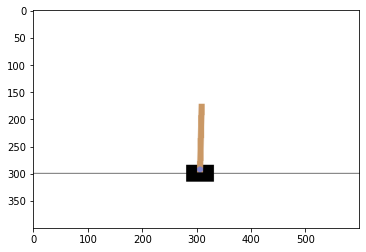

In [18]:
env = gym.make('CartPole-v1')
env.reset()
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(10):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)
  # time.sleep(0.01)
  if done:
    env.reset()
env.close()

In [19]:
observation

array([ 0.05274103, -0.04755165,  0.02369341,  0.18938453], dtype=float32)

In [20]:
def create_bins(num_bins_per_obs=10):
  bins_cart_position = np.linspace(-4.8,4.8,num_bins_per_obs)
  bins_cart_velocity = np.linspace(-5,5,num_bins_per_obs)
  bins_pole_angle = np.linspace(-0.418,0.418,num_bins_per_obs)
  bins_pole_ang_vel = np.linspace(-5,5,num_bins_per_obs)
  bins = np.array([bins_cart_position,bins_cart_velocity,
                   bins_pole_angle,bins_pole_ang_vel])
  return bins

In [21]:
NUM_BINS = 10
BINS = create_bins(NUM_BINS)

In [22]:
def discretize_observation(observations, bins):
    binned_observations = []
    for i, observation in enumerate(observations):
        discretized_observation = np.digitize(observation, bins[i])
        binned_observations.append(discretized_observation)
    return tuple(binned_observations) # Important for later indexing

In [23]:
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)
print(q_table.shape)

(10, 10, 10, 10, 2)


In [24]:
# Epsilon greedy action selection function
def epsilon_greedy_action_selection(epsilon,q_table,discrete_state):
  """
  Returns an action for the agent. Note how it uses a random
  exploration versus exploitation trade-off
  """
  random_number = np.random.random()
  # EXPLOITATION: USE BEST Q(s,a) Value
  if random_number > epsilon:
    action = np.argmax(q_table[discrete_state])
  # EXPLORATION: choose a random action
  else:
    action = np.random.randint(0, env.action_space.n)
  return action

In [25]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)


In [26]:
EPOCHS = 20000
ALPHA = 0.8
GAMMA = 0.9

In [27]:
epsilon = 1
BURN_IN = 1
EPSILON_END = 10000
EPSILON_REDUCE = 0.0001

In [28]:
def reduce_epsilon(epsilon, epoch):
  if BURN_IN <= epoch <= EPSILON_END:
    epsilon -= EPSILON_REDUCE
  return epsilon

In [29]:
def fail(done, points, reward):
  if done and points < 150:
    reward = -200
  return reward

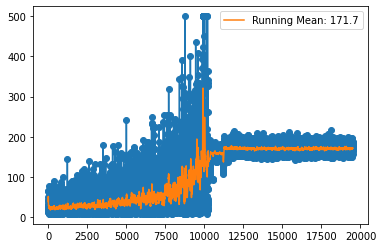

In [30]:
##############################################
### VISUALIZATION OF TRAINING PROGRESS ######
#############################################


log_interval = 500  # How often do we update the plot? (Just for performance reasons)
render_interval = 2000  # How often to render the game during training (If you want to watch your model learning)
### Here we set up the routine for the live plotting of the achieved points ######
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
##############################################
#############################################

points_log = []  # to store all achieved points
mean_points_log = []  # to store a running mean of the last 30 results
epochs = []  # store the epoch for plotting

for epoch in range(EPOCHS):
    
    ## Continuous State --> Discrete State
    
    initial_state = env.reset()  # get the initial observation
    discretized_state = discretize_observation(initial_state, BINS)  # map the observation to the bins
    
    done = False  # to stop current run when cartpole falls down   
    points = 0  # store result
    
    # Track Epochs for Plotting Visualization
    epochs.append(epoch)
    
    
    while not done:  # Perform current run as long as done is False (as long as the cartpole is up)
        
        # View how the cartpole is doing every render interval
#         if epoch % render_interval == 0:  
#             env.render()

        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)  # Epsilon-Greedy Action Selection 
        next_state, reward, done, info = env.step(action)  # perform action and get next state
        reward = fail(done, points, reward)  # Check if reward or fail state


        next_state_discretized = discretize_observation(next_state, BINS)  # map the next observation to the bins

        old_q_value =  q_table[discretized_state + (action,)]  # get the old Q-Value from the Q-Table
        next_optimal_q_value = np.max(q_table[next_state_discretized])  # Get the next optimal Q-Value
        

        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)  # Compute next Q-Value
        q_table[discretized_state + (action,)] = next_q  # Insert next Q-Value into the table

        discretized_state = next_state_discretized  # Update the old state
        points += 1

    epsilon = reduce_epsilon(epsilon, epoch)  # Reduce epsilon
    points_log.append(points)  # log overall achieved points for the current epoch
    running_mean = round(np.mean(points_log[-30:]), 2)  # Compute running mean points over the last 30 epochs
    mean_points_log.append(running_mean)  # and log it
    
    ################ Plot the points and running mean ##################
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, points_log)
        ax.plot(epochs, points_log)
        ax.plot(epochs, mean_points_log, label=f"Running Mean: {running_mean}")
        plt.legend()
        fig.canvas.draw()
  ######################################################################

env.close()


You got 181 points!


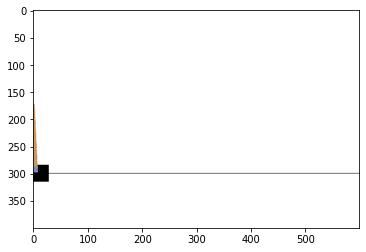

In [33]:
env.reset()
rewards = 0
img = plt.imshow(env.render('rgb_array')) # only call this once
for _ in range(1000):
  img.set_data(env.render('rgb_array')) # just update the data
  display.display(plt.gcf())
  display.clear_output(wait=True)
  discrete_state = discretize_observation(observation, BINS)  # get bins
  action = np.argmax(q_table[discrete_state])  # and chose action from the Q-Table
  observation, reward, done, info = env.step(action) # Finally perform the action
  rewards+=1
  if done:
      print(f"You got {rewards} points!")
      break
env.close()